# Lyrics LSTM with Cross Validation

In [1]:
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

from config import Configuration
import preprocess as pp
from models import LyricPredictor
from train import train

np.set_printoptions(threshold=np.inf)
%matplotlib inline

In [2]:
c = Configuration()
lyrics_dataset = pp.read_lyrics_files(c.path)
tokenized = pp.tokenize(lyrics_dataset)

Number of songs: 93


In [3]:
def cross_fold_validation(config, n_splits):
    print("Hyperparameters: ", config)
    x, y, dictionary = pp.preprocess(tokenized, config.window_size)

    skf = StratifiedKFold(n_splits=n_splits)

    valid_batch_size = int(y.shape[0] / n_splits)

    all_training_losses = []
    all_validation_losses = []

    for fold, (train_index, valid_index) in enumerate(skf.split(x,y)):
        print("fold: {} / {}".format(fold+1, n_splits))

        training_data = DataLoader(list(zip(x[train_index],y[train_index])), batch_size=config.train_batch_size, shuffle=True)
        validation_data = DataLoader(list(zip(x[valid_index],y[valid_index])), batch_size=config.valid_batch_size, shuffle=False)

        model = LyricPredictor(len(dictionary), config.output_size)

        model, training_losses, validation_losses = train(model, training_data, validation_data, config.num_epochs, config.lr, config.grad_max_norm)

        all_training_losses.append(training_losses) 
        all_validation_losses.append(validation_losses) 

    avg_training_losses = np.mean(np.array(all_training_losses), axis=0)
    avg_validation_losses = np.mean(np.array(all_validation_losses), axis=0)
    
    return avg_training_losses, avg_validation_losses

## Hyperparameter tuning

In [4]:
results = []
c = Configuration()

for window_size in [4]:
    c.window_size = window_size
    for num_epochs in [15]:
        c.num_epochs = num_epochs
        for train_batch_size in [64]:
            c.train_batch_size = train_batch_size
            for lr in [0.001]:
                c.lr = lr
                for output_size in [128]:
                    c.output_size = output_size
                    for n_splits in [2]:
                        avg_training_losses, avg_validation_losses = cross_fold_validation(c, n_splits)

                        results.append({ "config": c, "training": avg_training_losses, "validation": avg_validation_losses })
                        print("Average training loss: {} / validation loss: {}".format(avg_training_losses, avg_validation_losses))

Hyperparameters:  {'artist': 'nicki_minaj', 'path': 'lyrics/nicki_minaj', 'model_path': 'ckpt/model_nicki_minaj', 'window_size': 4, 'train_batch_size': 64, 'valid_batch_size': 64, 'output_size': 128, 'num_epochs': 15, 'lr': 0.001, 'grad_max_norm': 5, 'predict_topk': 5}
Vocabulary size:  5039


D:\Applications\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


fold: 1 / 2
epoch: 1 / 15
training loss: 5.927522237524228 / validation loss: 5.570751221351374
epoch: 2 / 15
training loss: 5.149066299654559 / validation loss: 5.4252903341987295
epoch: 3 / 15
training loss: 4.773908284235104 / validation loss: 5.3547286696423635
epoch: 4 / 15
training loss: 4.485676474041409 / validation loss: 5.332074667114059
epoch: 5 / 15
training loss: 4.250275464359192 / validation loss: 5.328261638259057
epoch: 6 / 15
training loss: 4.060689181803618 / validation loss: 5.351250288013799
epoch: 7 / 15
training loss: 3.9069273393917707 / validation loss: 5.389338854870765
epoch: 8 / 15
training loss: 3.7777274745741702 / validation loss: 5.429209136235688
epoch: 9 / 15
training loss: 3.66881042627987 / validation loss: 5.4815668664986275
epoch: 10 / 15
training loss: 3.5830234774836787 / validation loss: 5.536106660215424
epoch: 11 / 15
training loss: 3.5147002252358495 / validation loss: 5.591688820479482
epoch: 12 / 15
training loss: 3.45287055231647 / validat

## Visualization

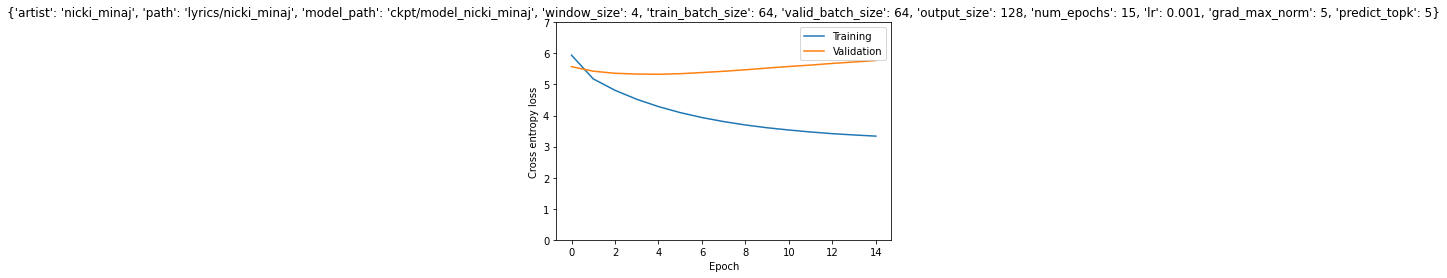

In [5]:
for results_index in range(len(results)):
    plt.plot(results[results_index]["training"], label="Training")
    plt.plot(results[results_index]["validation"], label="Validation")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Cross entropy loss")
    plt.ylim(top=7, bottom=0)
    plt.title(str(results[results_index]["config"]))
    plt.show()